<a href="https://colab.research.google.com/github/rami2ee3/DA_study/blob/main/boram_modeling3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# 1) 나눔폰트 설치
!apt-get -qq -y install fonts-nanum
!fc-cache -fv
!rm -rf ~/.cache/matplotlib


/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped directory detected
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache director

In [ ]:

# 2) 런타임 재시작 필요 ⚠️ (Ctrl+M -> Restart runtime)
import os, signal
os.kill(os.getpid(), signal.SIGKILL)


In [1]:

# 3) 재시작 후 다시 실행
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager as fm

# 설치된 폰트 확인
print([f for f in fm.findSystemFonts() if "Nanum" in f])

# 나눔고딕 경로 지정
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
fontprop = fm.FontProperties(fname=font_path)

# matplotlib 기본 폰트 교체
matplotlib.rc('font', family=fontprop.get_name())
matplotlib.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

print("현재 설정된 폰트:", matplotlib.rcParams['font.family'])


['/usr/share/fonts/truetype/nanum/NanumSquareB.ttf', '/usr/share/fonts/truetype/nanum/NanumGothic.ttf', '/usr/share/fonts/truetype/nanum/NanumSquareRoundR.ttf', '/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf', '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf', '/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf', '/usr/share/fonts/truetype/nanum/NanumSquareR.ttf', '/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf', '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf', '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf', '/usr/share/fonts/truetype/nanum/NanumGothicCodingBold.ttf', '/usr/share/fonts/truetype/nanum/NanumMyeongjoBold.ttf']
현재 설정된 폰트: ['NanumGothic']


In [2]:
# ==== 1) EDA + 전처리/피처/라벨 준비 ====
import pandas as pd
import numpy as np
import re, warnings
import matplotlib.pyplot as plt
import seaborn as sns

# 경로
TRAIN_PATH = "/content/drive/MyDrive/Colab Notebooks/elecClassification_train/train.csv"
TEST_PATH  = "/content/drive/MyDrive/Colab Notebooks/elecClassification_test/test.csv"

# 로드
train = pd.read_csv(TRAIN_PATH, encoding="utf-8")
test  = pd.read_csv(TEST_PATH,  encoding="utf-8")
print("[INFO] raw shapes:", train.shape, test.shape)

# 공통 유틸
DROP_CANDIDATES = ["index", "Index", "ID", "Id", "Unnamed: 0"]
def drop_useless(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    for c in DROP_CANDIDATES:
        if c in out.columns:
            out.drop(columns=c, inplace=True)
    return out

def add_phase_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    for phase in ["R","S","T"]:
        p_kw  = f"{phase}상유효전력"
        q_kvar= f"{phase}상무효전력"
        if p_kw in out.columns and q_kvar in out.columns:
            out[f"{phase}전력합"] = np.sqrt(out[p_kw]**2 + out[q_kvar]**2)
            denom = out[f"{phase}전력합"].replace(0, np.nan)
            out[f"{phase}역률"] = (out[p_kw] / denom).fillna(0.0).clip(-1, 1)
    if all(f"{p}전력합" in out.columns for p in ["R","S","T"]):
        out["총전력합"] = out["R전력합"] + out["S전력합"] + out["T전력합"]
    return out

# 불필요 컬럼 제거 → 파생 피처
train = add_phase_features(drop_useless(train))
test  = add_phase_features(drop_useless(test))

# 수치형/라벨 정의
label_cols = ["label_역률평균","label_전류고조파평균","label_전압고조파평균"]
num_train_all = train.select_dtypes(include=np.number).columns
num_test_all  = test.select_dtypes(include=np.number).columns
num_features_train = [c for c in num_train_all if c not in label_cols]
num_features_test  = list(num_test_all)


[INFO] raw shapes: (2420565, 27) (313267, 24)


In [3]:

# === EDA 1: 결측 요약
print("\n[EDA] 결측 비율 상위(Train)")
miss_rate = train[num_features_train].isna().mean().sort_values(ascending=False)
print((miss_rate.head(15)*100).round(2).astype(str) + "%")

print("\n[EDA] 결측 비율 상위(Test)")
miss_rate_te = test[num_features_test].isna().mean().sort_values(ascending=False)
print((miss_rate_te.head(15)*100).round(2).astype(str) + "%")



[EDA] 결측 비율 상위(Train)
총전력합      0.12%
T전력합      0.12%
T상유효전력    0.12%
T상무효전력    0.12%
T상전류      0.12%
T상전압      0.12%
T상선간전압    0.12%
S상선간전압    0.06%
S상유효전력    0.06%
S상무효전력    0.06%
S전력합      0.06%
S상전압      0.06%
S상전류      0.06%
R상선간전압     0.0%
R상전압       0.0%
dtype: object

[EDA] 결측 비율 상위(Test)
누적전력량     0.02%
유효전력평균    0.02%
무효전력평균    0.02%
주파수       0.02%
전류평균      0.02%
상전압평균     0.02%
선간전압평균    0.02%
온도        0.02%
R상유효전력    0.02%
R상무효전력    0.02%
R상전류      0.02%
R상전압      0.02%
R상선간전압    0.02%
S상유효전력    0.02%
S상무효전력    0.02%
dtype: object


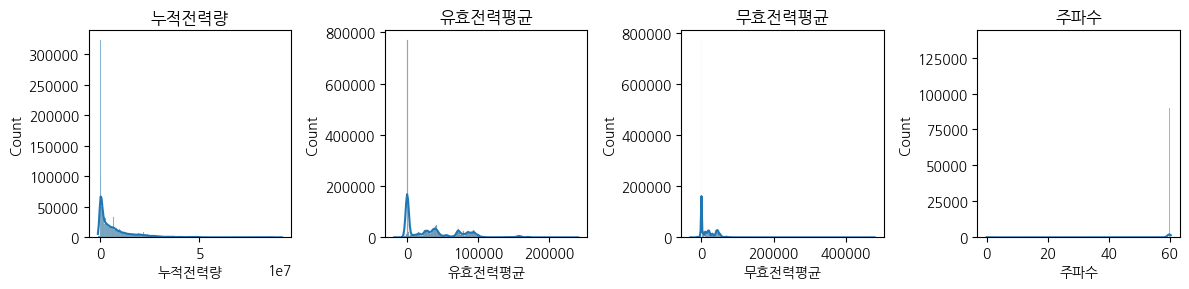

In [4]:

# === EDA 2: 히스토그램 (상위 4개만 예시)
plt.figure(figsize=(12,3))
cols_show = num_features_train[:4]
for i, col in enumerate(cols_show, 1):
    plt.subplot(1,4,i)
    sns.histplot(train[col], kde=True)
    plt.title(col)
plt.tight_layout(); plt.show()


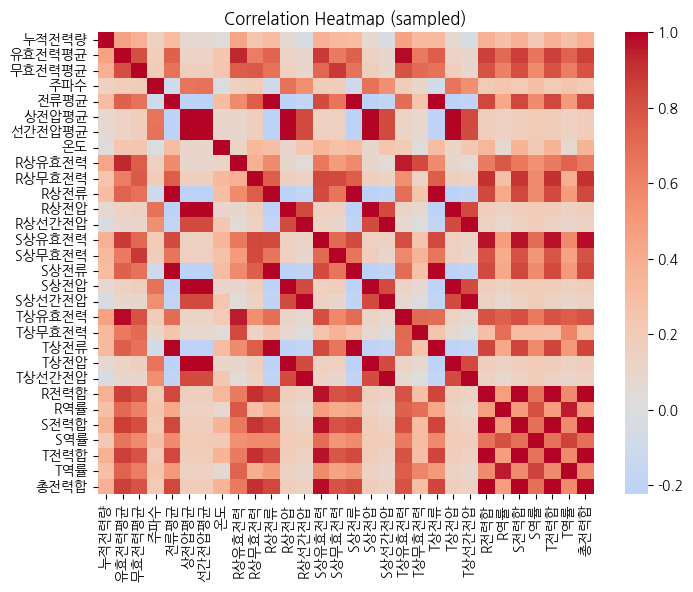

In [5]:

# === EDA 3: 상관 히트맵(샘플 5k로 속도절충)
sampled = train[num_features_train].sample(n=min(5000, len(train)), random_state=42)
plt.figure(figsize=(8,6))
corr = sampled.corr(numeric_only=True)
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (sampled)"); plt.show()


In [6]:

# 라벨 매핑
label_map = {"정상":0, "주의":1, "경고":2}
for c in label_cols:
    if c in train.columns:
        train[c] = train[c].astype(str).str.strip().map(label_map)

# 라벨 결측 드롭
before = len(train)
train = train.dropna(subset=[c for c in label_cols if c in train.columns]).reset_index(drop=True)
print(f"[INFO] dropped rows with NaN labels: {before-len(train)} (remain {len(train)})")

# 중앙값(Train 기준)으로 결측 대치 → test에도 동일 적용(데이터 누수 방지)
train_medians = train[num_features_train].median(numeric_only=True)
train[num_features_train] = train[num_features_train].fillna(train_medians)
test[num_features_test]   = test[num_features_test].fillna(train_medians.reindex(num_features_test))

# 최종 공통 피처(라벨 제외) 고정
num_train = train.select_dtypes(include=np.number).columns
num_test  = test.select_dtypes(include=np.number).columns
feature_cols = [c for c in num_train.intersection(num_test) if c not in label_cols]

X_train = train[feature_cols].copy()
y_train = train[label_cols].astype(int).copy()
X_test  = test[feature_cols].copy()

print(f"[INFO] features={len(feature_cols)} | X_train={X_train.shape} | y_train={y_train.shape} | X_test={X_test.shape}")


[INFO] dropped rows with NaN labels: 0 (remain 2420565)
[INFO] features=30 | X_train=(2420565, 30) | y_train=(2420565, 3) | X_test=(313267, 30)


In [7]:
# ==== 2) Modeling (DataFrameImputer + 컬럼명 유지 + class_weight=balanced) ====
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn import set_config

# 파이프라인에서 변환 결과를 DataFrame으로 유지
set_config(transform_output="pandas")

# --- DataFrameImputer: median으로 대치 + 컬럼명/인덱스 유지 ---
class DataFrameImputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy="median"):
        self.strategy = strategy
        self.fill_values_ = None
    def fit(self, X, y=None):
        X = pd.DataFrame(X).copy()
        if self.strategy == "median":
            self.fill_values_ = X.median(numeric_only=False)
        elif self.strategy == "mean":
            self.fill_values_ = X.mean(numeric_only=False)
        else:
            raise ValueError("strategy must be 'median' or 'mean'")
        return self
    def transform(self, X):
        X = pd.DataFrame(X).copy()
        return X.fillna(self.fill_values_)


In [8]:

# 모델 선택 (LightGBM 우선)
try:
    import lightgbm as lgb
    BaseClf = lgb.LGBMClassifier
    clf_params = dict(objective="multiclass", num_class=3, class_weight="balanced",
                      n_estimators=300, learning_rate=0.05, random_state=42)
    print("[INFO] Using LightGBM")
except Exception as e:
    from sklearn.ensemble import RandomForestClassifier
    BaseClf = RandomForestClassifier
    clf_params = dict(n_estimators=300, class_weight="balanced",
                      random_state=42, n_jobs=-1)
    print("[WARN] lightgbm not available → RandomForest:", e)

# 파이프라인: Imputer만 (스케일링 불필요; 트리계)
pipe = Pipeline([
    ("imputer", DataFrameImputer(strategy="median")),
    ("clf", BaseClf(**clf_params))
])

# 검증 분리(역률 라벨을 대표 stratify; 불가하면 None)
strat = y_train["label_역률평균"] if y_train["label_역률평균"].nunique() > 1 else None
if strat is None:
    print("[WARN] stratify 불가 → 무작위 분할")
X_tr, X_va, y_tr_all, y_va_all = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=strat
)


[INFO] Using LightGBM


In [9]:

# 타깃별 학습/평가/예측
label_cols = ["label_역률평균","label_전류고조파평균","label_전압고조파평균"]
reports = {}
pred_labels = {}
pred_probas = {}

for tgt in label_cols:
    pipe.fit(X_tr, y_tr_all[tgt])
    y_va_pred = pipe.predict(X_va)
    reports[tgt] = classification_report(y_va_all[tgt], y_va_pred, digits=4, zero_division=0)
    print(f"\n=== Validation Report: {tgt} ===\n{reports[tgt]}")

    # test 예측
    pred_labels[tgt] = pipe.predict(X_test)

    # 클래스-확률 매핑 (클래스 순서 안전)
    proba = None
    try:
        proba = pipe.predict_proba(X_test)   # (n, n_classes)
        classes_ = pipe.named_steps["clf"].classes_
        # classes_가 [0,1,2] 순서일 경우만 바로 쓰고, 아니면 재매핑
        if proba is not None and hasattr(classes_, "__iter__"):
            # (n,3) 배열로 정렬
            proba_df = pd.DataFrame(proba, columns=classes_)
            # 누락 클래스는 0 확률로 채움
            for cls in [0,1,2]:
                if cls not in proba_df.columns:
                    proba_df[cls] = 0.0
            proba = proba_df[[0,1,2]].to_numpy()
    except Exception:
        pass
    pred_probas[tgt] = proba


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.184203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7576
[LightGBM] [Info] Number of data points in the train set: 1936452, number of used features: 30
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612

=== Validation Report: label_역률평균 ===
              precision    recall  f1-score   support

           0     0.9921    0.9515    0.9714    263476
           1     0.6645    0.9438    0.7799     30875
           2     0.9929    0.9816    0.9872    189762

    accuracy                         0.9628    484113
   macro avg     0.8832    0.9589    0.9128    484113
weighted avg     0.9716    0.9628    0.9654    484113

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the o

In [ ]:

# 결과 저장
out = pd.DataFrame(index=X_test.index)
for tgt in label_cols:
    out[f"pred_{tgt}"] = pred_labels[tgt]
    proba = pred_probas[tgt]
    if proba is not None and proba.ndim == 2 and proba.shape[1] >= 3:
        out[f"{tgt}_정상_%"] = (proba[:,0]*100).round(2)
        out[f"{tgt}_주의_%"] = (proba[:,1]*100).round(2)
        out[f"{tgt}_경고_%"] = (proba[:,2]*100).round(2)

SAVE_PATH = "predictions_model_improved.csv"
out.to_csv(SAVE_PATH, index=False, encoding="utf-8-sig")
print("[INFO] Saved:", SAVE_PATH)


In [ ]:
# === 3) Bundle Export with Helper Code ===
import joblib, json, datetime, platform, importlib

# --- Meta 정보 ---
def _modver(name):
    try: return importlib.import_module(name).__version__
    except: return None

meta = {
    "created_at": datetime.datetime.utcnow().strftime("%Y-%m-%dT%H:%M:%SZ"),
    "python": platform.python_version(),
    "libs": {
        "pandas": _modver("pandas"),
        "numpy": _modver("numpy"),
        "scikit_learn": _modver("sklearn"),
        "lightgbm": _modver("lightgbm"),
    }
}

schema = {
    "feature_cols": list(map(str, feature_cols)),
    "label_cols": list(map(str, label_cols)),
    "label_map": {"정상":0, "주의":1, "경고":2}
}

# --- Helper 함수 코드 (문자열) ---
helper_code = r"""
def predict_bundle(bundle, df_new):
    X = df_new[bundle["feature_cols"]]
    pipe = bundle["pipeline"]
    y_pred = pipe.predict(X)
    try:
        y_proba = pipe.predict_proba(X)
    except Exception:
        y_proba = None
    return y_pred, y_proba
"""


[INFO] Saved bundle → model_bundle_improved.pkl


/tmp/ipython-input-984124316.py:10: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "created_at": datetime.datetime.utcnow().strftime("%Y-%m-%dT%H:%M:%SZ"),


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

# --- Bundle 객체 ---
bundle = {
    "pipeline": pipe,
    "feature_cols": feature_cols,
    "label_cols": label_cols,
    "label_map": {"정상":0,"주의":1,"경고":2},
    "meta": meta,
    "schema": schema,
    "helper_code": helper_code   # 함수 코드도 같이 저장
}

# --- 저장 ---
PKL_PATH = "model_bundle_improved.pkl"
joblib.dump(bundle, PKL_PATH)
print(f"[INFO] Saved bundle → {PKL_PATH}")

# --- Colab → 로컬 다운로드 ---
try:
    from google.colab import files
    files.download(PKL_PATH)
except ImportError:
    pass


In [ ]:
bundle = joblib.load("model_bundle_improved.pkl")

# helper 코드 로드
exec(bundle["helper_code"], globals())

# 이제 predict_bundle() 사용 가능
import pandas as pd
df_new = pd.DataFrame([...], columns=bundle["feature_cols"])
y_pred, y_proba = predict_bundle(bundle, df_new)


ValueError: Shape of passed values is (1, 1), indices imply (1, 30)